In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

# --- CONFIGURATION ---
sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (12, 6)
plt.rcParams['font.size'] = 11

COLOR_MAIN = '#a6cee3' 
COLOR_LINE_1 = '#1f78b4'
COLOR_LINE_2 = '#33a02c' 
COLOR_SCATTER = '#1f78b4'

INPUT_FILE = 'prs.csv'

TARGET_ORGS = ['lablivre-unb', 'GovHub-br', 'lappis-unb'] 

df = pd.read_csv(INPUT_FILE)

if 'org' in df.columns and TARGET_ORGS:
    if isinstance(TARGET_ORGS, str):
        TARGET_ORGS = [TARGET_ORGS]
        
    original_count = len(df)
    df = df[df['org'].isin(TARGET_ORGS)].copy()
    
    if len(TARGET_ORGS) > 1:
        org_title = "LABLIVRE"
    else:
        org_title = TARGET_ORGS[0]
        
    print("--- FILTRO APLICADO ---")
    print(f"Orgs Selecionadas: {TARGET_ORGS}")
    print(f"Registros: {len(df)} (de {original_count})")
else:
    org_title = "All Organizations"
    print("Analisando TODAS as organizações do arquivo (Filtro vazio ou coluna inexistente).")

--- FILTRO APLICADO ---
Orgs Selecionadas: ['lablivre-unb', 'GovHub-br', 'lappis-unb']
Registros: 3263 (de 7497)


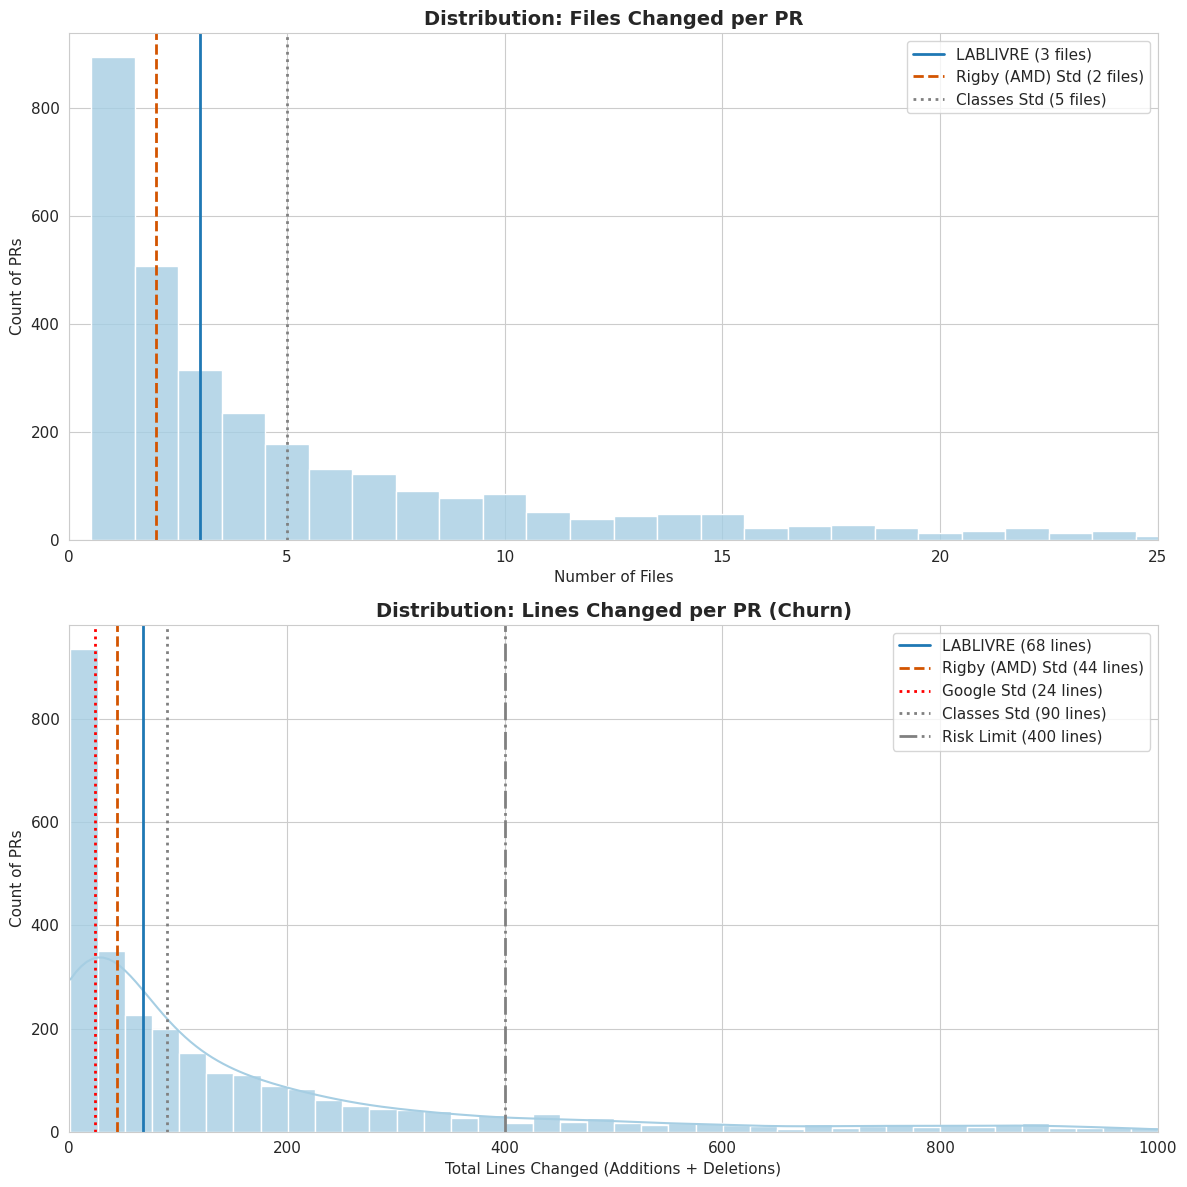

In [11]:
def plot_size_complexity_multi_bench(df):

    clean_df = df[(df['files_changed'] > 0) & (df['churn'] > 0)].copy()
    
    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 12))
    
    p50_files = clean_df['files_changed'].median()
    subset_files = clean_df[clean_df['files_changed'] <= 25]['files_changed']
    
    sns.histplot(subset_files, discrete=True, color=COLOR_MAIN, edgecolor='white', alpha=0.8, ax=ax1)
    
    ax1.axvline(p50_files, color=COLOR_LINE_1, linewidth=2, linestyle='-', label=f'{org_title} ({p50_files:.0f} files)')

    rigby_amd_files = 2 
    ax1.axvline(rigby_amd_files, color='#d35400', linewidth=2, linestyle='--', label=f'Rigby (AMD) Std ({rigby_amd_files} files)')

    classes_files = 5
    ax1.axvline(classes_files, color='gray', linewidth=2, linestyle=':', label=f'Classes Std ({classes_files} files)')
    
    
    ax1.set_title('Distribution: Files Changed per PR', fontsize=14, fontweight='bold')
    ax1.set_xlabel('Number of Files')
    ax1.set_ylabel('Count of PRs')
    ax1.set_xlim(0, 25)
    ax1.legend()

    subset_churn = clean_df[clean_df['churn'] <= 1000]['churn']
    p50_churn = subset_churn.median()
    
    sns.histplot(subset_churn, binwidth=25, kde=True, color=COLOR_MAIN, edgecolor='white', alpha=0.8, ax=ax2)
    
    ax2.axvline(p50_churn, color=COLOR_LINE_1, linewidth=2, linestyle='-', label=f'{org_title} ({p50_churn:.0f} lines)')
    
    rigby_amd_churn = 44
    ax2.axvline(rigby_amd_churn, color='#d35400', linewidth=2, linestyle='--', label=f'Rigby (AMD) Std ({rigby_amd_churn} lines)')

    google_churn = 24
    ax2.axvline(google_churn, color='red', linewidth=2, linestyle=':', label=f'Google Std ({google_churn} lines)')

    classes_churn = 90
    ax2.axvline(classes_churn, color='gray', linewidth=2, linestyle=':', label=f'Classes Std ({classes_churn} lines)')
    
    
    review_limit = 400
    ax2.axvline(review_limit, color='gray', linewidth=2, linestyle='-.', label=f'Risk Limit ({review_limit} lines)')
    
    ax2.set_title('Distribution: Lines Changed per PR (Churn)', fontsize=14, fontweight='bold')
    ax2.set_xlabel('Total Lines Changed (Additions + Deletions)')
    ax2.set_ylabel('Count of PRs')
    ax2.set_xlim(0, 1000)
    ax2.legend()
    
    plt.tight_layout()
    plt.show()

plot_size_complexity_multi_bench(df)

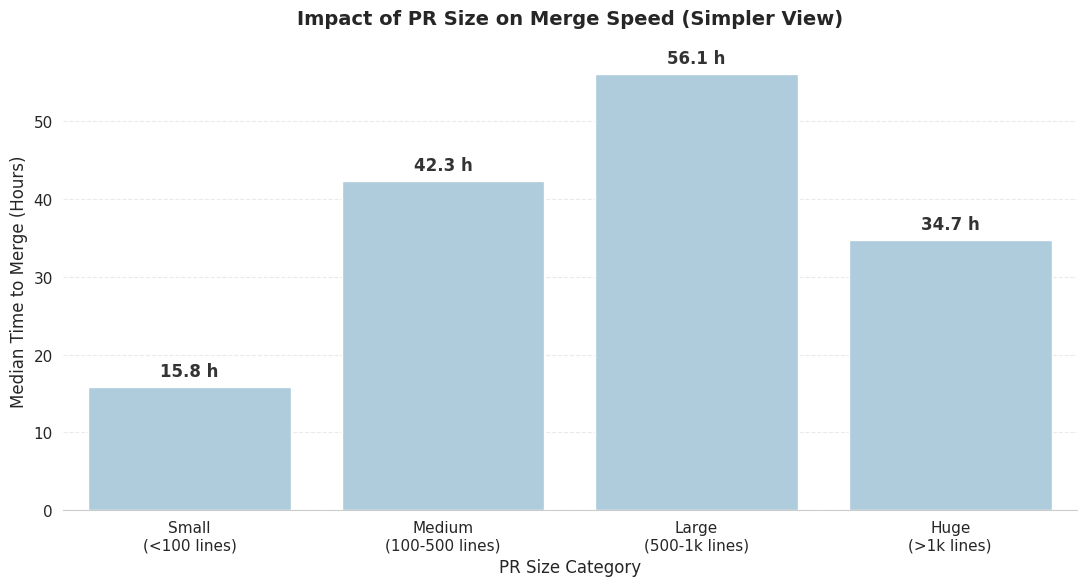

In [3]:
def plot_merge_time_vs_size_simple(df):
    plt.figure(figsize=(11, 6))
    
    def get_category(churn):
        if churn < 100: return "Small\n(<100 lines)"
        if churn < 500: return "Medium\n(100-500 lines)"
        if churn < 1000: return "Large\n(500-1k lines)"
        return "Huge\n(>1k lines)"
    
    df_viz = df.copy()
    df_viz['Size Category'] = df_viz['churn'].apply(get_category)
    
    order = ["Small\n(<100 lines)", "Medium\n(100-500 lines)", "Large\n(500-1k lines)", "Huge\n(>1k lines)"]
    
    ax = sns.barplot(
        data=df_viz, 
        x='Size Category', 
        y='lead_time_hours', 
        estimator=np.median,
        order=order,
        errorbar=None, 
        color=COLOR_MAIN
    )
    
    for container in ax.containers:
        ax.bar_label(container, fmt='%.1f h', padding=5, fontsize=12, fontweight='bold', color='#333333')
    
    plt.title('Impact of PR Size on Merge Speed (Simpler View)', fontsize=14, pad=20, fontweight='bold')
    plt.xlabel('PR Size Category', fontsize=12)
    plt.ylabel('Median Time to Merge (Hours)', fontsize=12)
    
    sns.despine(left=True)
    plt.grid(axis='y', linestyle='--', alpha=0.4) 
    
    plt.tight_layout()
    plt.show()

plot_merge_time_vs_size_simple(df)

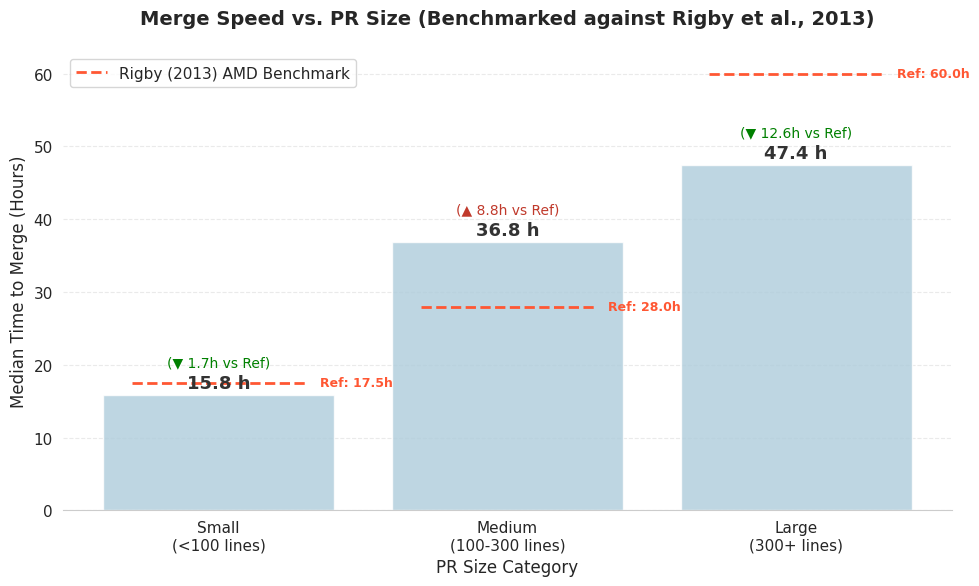

In [4]:
def plot_merge_time_vs_size_with_benchmark(df):
    plt.figure(figsize=(10, 6))
    
    def get_category(churn):
        if churn < 100:
            return "Small\n(<100 lines)"
        if churn <= 300:
            return "Medium\n(100-300 lines)"
        return "Large\n(300+ lines)"
    
    df_viz = df.copy()
    df_viz['Size Category'] = df_viz['churn'].apply(get_category)
    order = ["Small\n(<100 lines)", "Medium\n(100-300 lines)", "Large\n(300+ lines)"]
    
    ax = sns.barplot(
        data=df_viz, 
        x='Size Category', 
        y='lead_time_hours', 
        estimator=np.median, 
        order=order,
        errorbar=None, 
        color=COLOR_MAIN,
        alpha=0.8
    )

    benchmarks = {
        0: 17.5, # Small: Benchmark AMD (Rigby 2013)
        1: 28.0, # Medium: Estimativa de degradação linear 
        2: 60.0  # Large: Zona de Risco (Industry Avg)
    }
    
    for idx, target in benchmarks.items():
        ax.hlines(y=target, xmin=idx-0.3, xmax=idx+0.3, colors='#FF5733', linestyles='--', linewidth=2)
        
        ax.text(idx+0.35, target, f'Ref: {target}h', va='center', fontsize=9, color='#FF5733', fontweight='bold')

    medians = df_viz.groupby('Size Category')['lead_time_hours'].median()
    
    for i, category in enumerate(order):
        actual = medians[category]
        benchmark = benchmarks[i]
        
        delta_color = 'green' if actual <= benchmark else '#c0392b'
        delta_symbol = '▼' if actual <= benchmark else '▲'
        
        ax.text(i, actual + 1, f'{actual:.1f} h', ha='center', fontsize=13, fontweight='bold', color='#333')
        
        diff = actual - benchmark
        ax.text(i, actual + 4, f'({delta_symbol} {abs(diff):.1f}h vs Ref)', ha='center', fontsize=10, color=delta_color)

    plt.title('Merge Speed vs. PR Size (Benchmarked against Rigby et al., 2013)', fontsize=14, pad=20, fontweight='bold')
    plt.xlabel('PR Size Category', fontsize=12)
    plt.ylabel('Median Time to Merge (Hours)', fontsize=12)
    
    import matplotlib.lines as mlines
    ref_line = mlines.Line2D([], [], color='#FF5733', linestyle='--', linewidth=2, label='Rigby (2013) AMD Benchmark')
    plt.legend(handles=[ref_line], loc='upper left')
    
    sns.despine(left=True)
    plt.grid(axis='y', linestyle='--', alpha=0.4)
    plt.tight_layout()
    plt.show()

plot_merge_time_vs_size_with_benchmark(df)

In [5]:
summary_metrics = {
    'Total PRs': len(df),
    'Median Files Changed': df['files_changed'].median(),
    'Median Lead Time (h)': df['lead_time_hours'].median(),
    'Median Time to First Review (h)': df['time_to_first_review_hours'].median(),
    'Review Coverage (%)': (df['reviews_count'] > 0).mean() * 100
}

summary_df = pd.Series(summary_metrics).round(2).to_frame("Value")
print("--- Executive Summary (Seporaitis Metrics) ---")
display(summary_df)

--- Executive Summary (Seporaitis Metrics) ---


,Value
Total PRs,3263.00
Median Files Changed,3.00
Median Lead Time (h),23.18
Median Time to First Review (h),18.85
Review Coverage (%),61.78


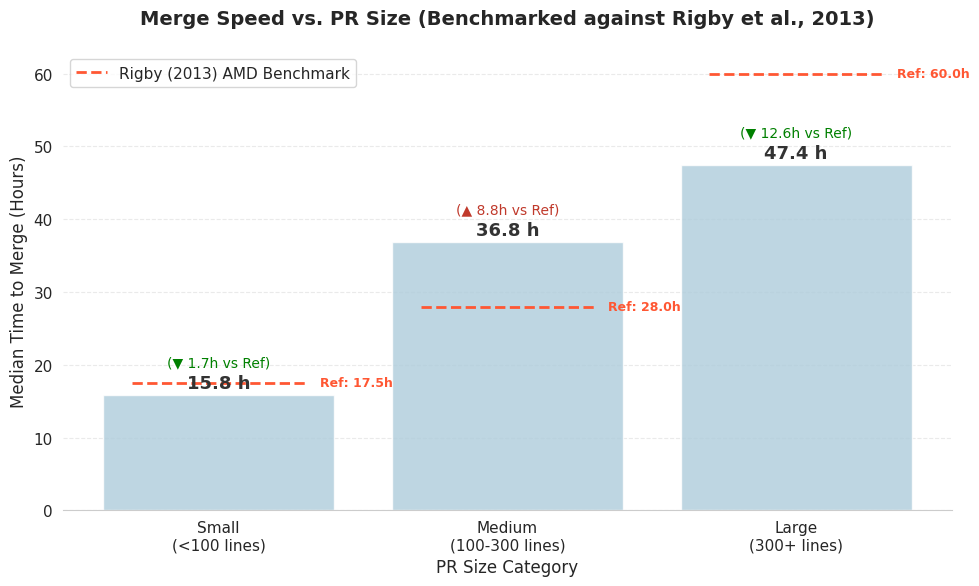

In [6]:
def plot_merge_time_vs_size_with_benchmark(df):
    plt.figure(figsize=(10, 6))
    
    # 1. Categorizar (Mesma lógica anterior)
    def get_category(churn):
        if churn < 100: return "Small\n(<100 lines)"
        if churn <= 300: return "Medium\n(100-300 lines)"
        return "Large\n(300+ lines)"
    
    df_viz = df.copy()
    df_viz['Size Category'] = df_viz['churn'].apply(get_category)
    order = ["Small\n(<100 lines)", "Medium\n(100-300 lines)", "Large\n(300+ lines)"]
    
    ax = sns.barplot(
        data=df_viz, 
        x='Size Category', 
        y='lead_time_hours', 
        estimator=np.median, 
        order=order,
        errorbar=None, 
        color=COLOR_MAIN,
        alpha=0.8
    )
    
    benchmarks = {
        0: 17.5, # Small: Benchmark AMD (Rigby 2013)
        1: 28.0, # Medium: Estimativa de degradação linear
        2: 60.0  # Large: Zona de Risco (Industry Avg)
    }
    
    for idx, target in benchmarks.items():
        ax.hlines(y=target, xmin=idx-0.3, xmax=idx+0.3, colors='#FF5733', linestyles='--', linewidth=2)
        
        ax.text(idx+0.35, target, f'Ref: {target}h', va='center', fontsize=9, color='#FF5733', fontweight='bold')

    medians = df_viz.groupby('Size Category')['lead_time_hours'].median()
    
    for i, category in enumerate(order):
        actual = medians[category]
        benchmark = benchmarks[i]
        
        delta_color = 'green' if actual <= benchmark else '#c0392b'
        delta_symbol = '▼' if actual <= benchmark else '▲'
        
        ax.text(i, actual + 1, f'{actual:.1f} h', ha='center', fontsize=13, fontweight='bold', color='#333')
        
        diff = actual - benchmark
        ax.text(i, actual + 4, f'({delta_symbol} {abs(diff):.1f}h vs Ref)', ha='center', fontsize=10, color=delta_color)

    plt.title('Merge Speed vs. PR Size (Benchmarked against Rigby et al., 2013)', fontsize=14, pad=20, fontweight='bold')
    plt.xlabel('PR Size Category', fontsize=12)
    plt.ylabel('Median Time to Merge (Hours)', fontsize=12)
    
    import matplotlib.lines as mlines
    ref_line = mlines.Line2D([], [], color='#FF5733', linestyle='--', linewidth=2, label='Rigby (2013) AMD Benchmark')
    plt.legend(handles=[ref_line], loc='upper left')
    
    sns.despine(left=True)
    plt.grid(axis='y', linestyle='--', alpha=0.4)
    plt.tight_layout()
    plt.show()

plot_merge_time_vs_size_with_benchmark(df)

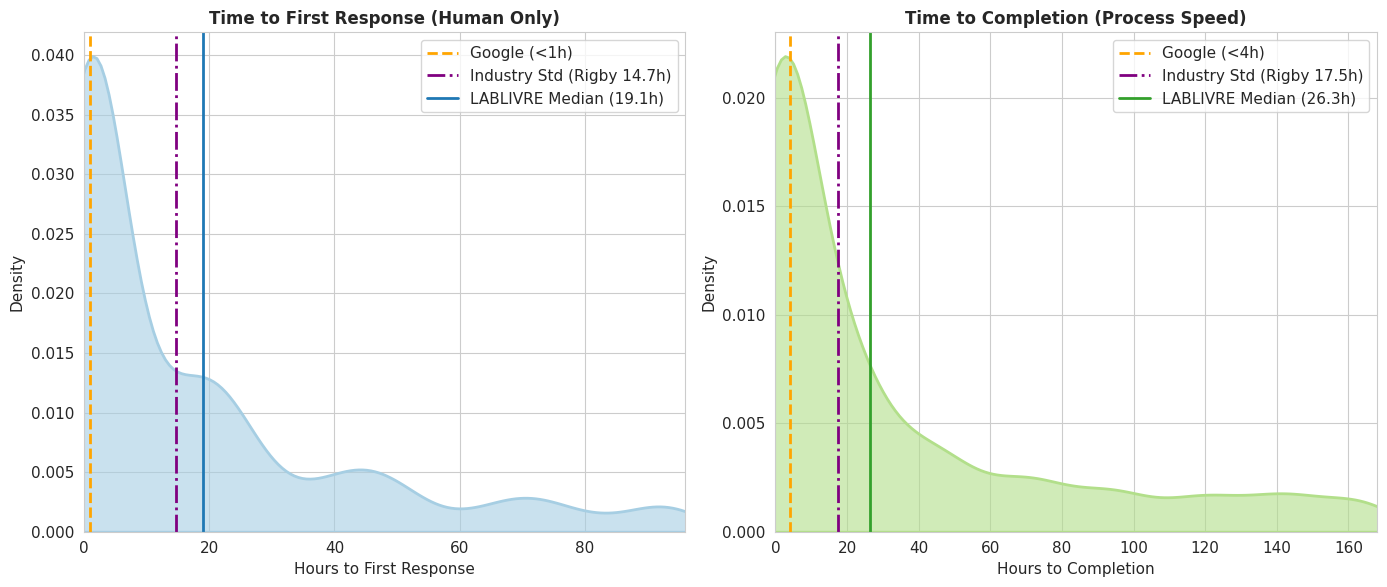

--- Comparativo com Rigby & Bird (2013) ---
Fonte dos Dados: Table 2 'Descriptive statistics of the projects'
--------------------------------------------------
1. TIME TO FIRST RESPONSE:
   - Industry Benchmark (Microsoft Bing): 14.7 h
     (Nota: O Bing foi o projeto comercial mais rápido do estudo.)
   - Target Google/Lyst: <1.0 h
   - SEU TIME: 19.1 h

2. TIME TO COMPLETION:
   - Industry Benchmark (AMD): 17.5 h
   - SEU TIME: 26.3 h


In [ ]:
def plot_review_speed_rigby_final(df):
    clean_response = df[df['time_to_first_review_hours'] > 0.01]['time_to_first_review_hours']
    clean_completion = df[df['lead_time_hours'] > 0.01]['lead_time_hours']
    
    viz_response = clean_response[clean_response <= 96]
    viz_completion = clean_completion[clean_completion <= 168]

    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 6))
    
    sns.kdeplot(viz_response, fill=True, color=COLOR_MAIN, alpha=0.6, linewidth=2, ax=ax1)
    
    real_median_resp = clean_response.median()
    
    ax1.axvline(1, color='orange', linestyle='--', linewidth=2, label='Google (<1h)')
    ax1.axvline(14.7, color='purple', linestyle='-.', linewidth=2, label='Industry Std (Rigby 14.7h)')
    ax1.axvline(real_median_resp, color=COLOR_LINE_1, linewidth=2, label=f'{org_title} Median ({real_median_resp:.1f}h)')
    
    ax1.set_title('Time to First Response (Human Only)', fontsize=12, fontweight='bold')
    ax1.set_xlabel('Hours to First Response')
    ax1.set_xlim(0, 96)
    ax1.legend()

    sns.kdeplot(viz_completion, fill=True, color='#b2df8a', alpha=0.6, linewidth=2, ax=ax2)
    
    real_median_comp = clean_completion.median()
    
    ax2.axvline(4, color='orange', linestyle='--', linewidth=2, label='Google (<4h)')
    ax2.axvline(17.5, color='purple', linestyle='-.', linewidth=2, label='Industry Std (Rigby 17.5h)')
    ax2.axvline(real_median_comp, color=COLOR_LINE_2, linewidth=2, label=f'{org_title} Median ({real_median_comp:.1f}h)')
    
    ax2.set_title('Time to Completion (Process Speed)', fontsize=12, fontweight='bold')
    ax2.set_xlabel('Hours to Completion')
    ax2.set_xlim(0, 168)
    ax2.legend()
    
    plt.tight_layout()
    plt.show()
    

plot_review_speed_rigby_final(df)


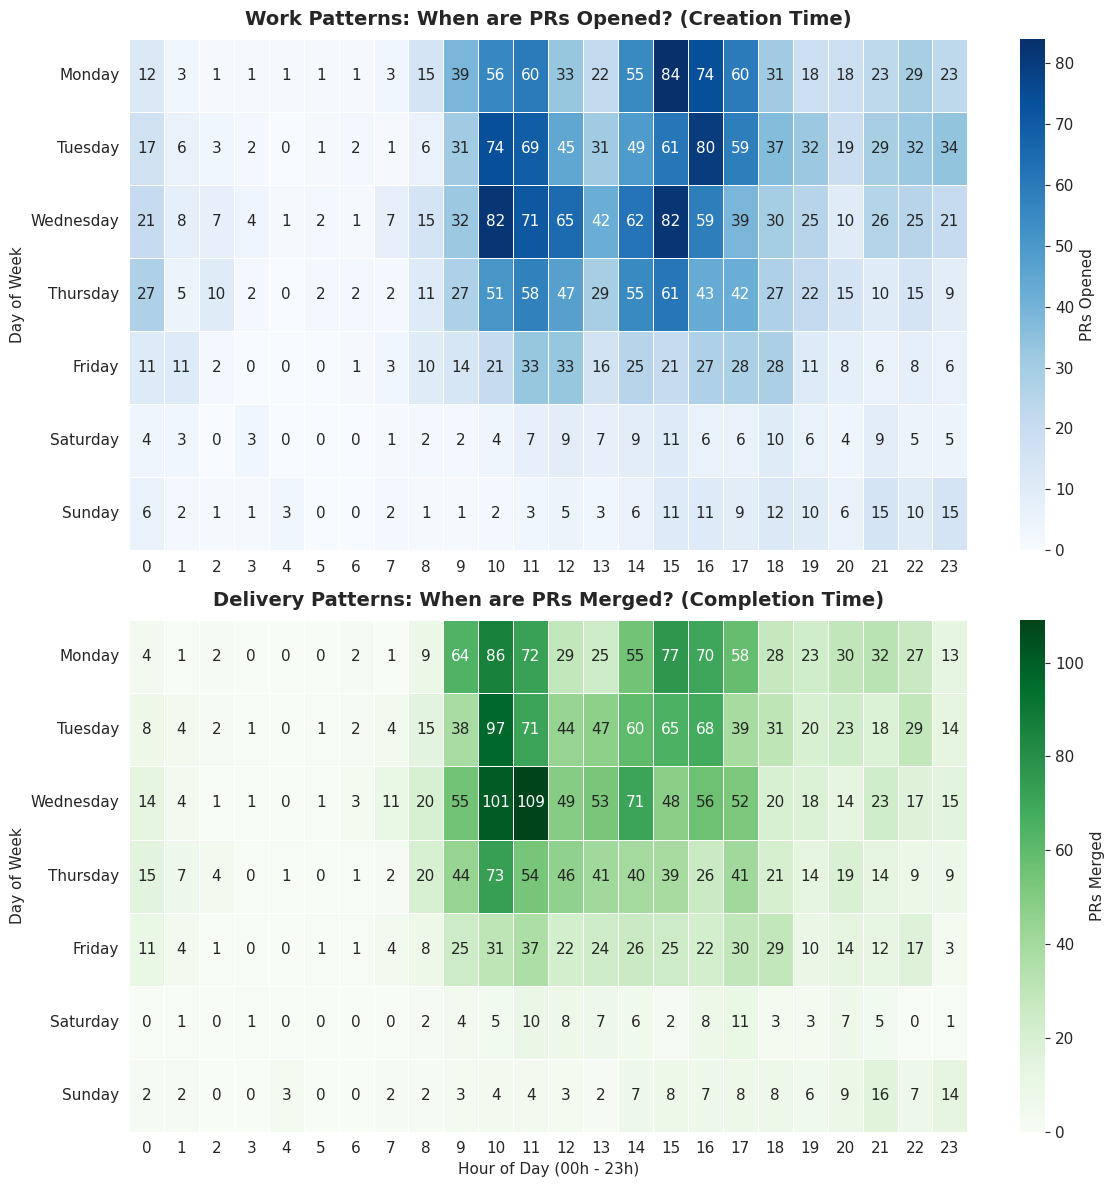

In [8]:
def plot_activity_heatmaps(df):
    df = df.copy()
    df['created_at'] = pd.to_datetime(df['created_at'], utc=True)
    df['merged_at'] = pd.to_datetime(df['merged_at'], utc=True)

    try:
        df['created_at_br'] = df['created_at'].dt.tz_convert('America/Sao_Paulo')
        df['merged_at_br'] = df['merged_at'].dt.tz_convert('America/Sao_Paulo')
    except Exception as e:
        print(f"Timezone conversion warning: {e}. Using UTC.")
        df['created_at_br'] = df['created_at']
        df['merged_at_br'] = df['merged_at']

    def get_heatmap_data(column):
        temp = df[['id', column]].dropna().copy()
        temp['day_name'] = temp[column].dt.day_name()
        temp['hour'] = temp[column].dt.hour
        
        pivot = temp.groupby(['day_name', 'hour']).size().unstack(fill_value=0)
        
        days_order = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
        pivot = pivot.reindex(days_order)
        
        for h in range(24):
            if h not in pivot.columns:
                pivot[h] = 0
        return pivot[sorted(pivot.columns)]

    creation_matrix = get_heatmap_data('created_at_br')
    merge_matrix = get_heatmap_data('merged_at_br')

    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 12))
    
    sns.heatmap(
        creation_matrix,
        cmap='Blues',
        annot=True,
        fmt='d',
        linewidths=.5,
        ax=ax1,
        cbar_kws={'label': 'PRs Opened'}
    )
    ax1.set_title(
        'Work Patterns: When are PRs Opened? (Creation Time)',
        fontsize=14,
        fontweight='bold',
        pad=10
    )
    ax1.set_ylabel('Day of Week')
    ax1.set_xlabel('')

    sns.heatmap(
        merge_matrix,
        cmap='Greens',
        annot=True,
        fmt='d',
        linewidths=.5,
        ax=ax2,
        cbar_kws={'label': 'PRs Merged'}
    )
    ax2.set_title(
        'Delivery Patterns: When are PRs Merged? (Completion Time)',
        fontsize=14,
        fontweight='bold',
        pad=10
    )
    ax2.set_ylabel('Day of Week')
    ax2.set_xlabel('Hour of Day (00h - 23h)')

    plt.tight_layout()
    plt.show()

plot_activity_heatmaps(df)


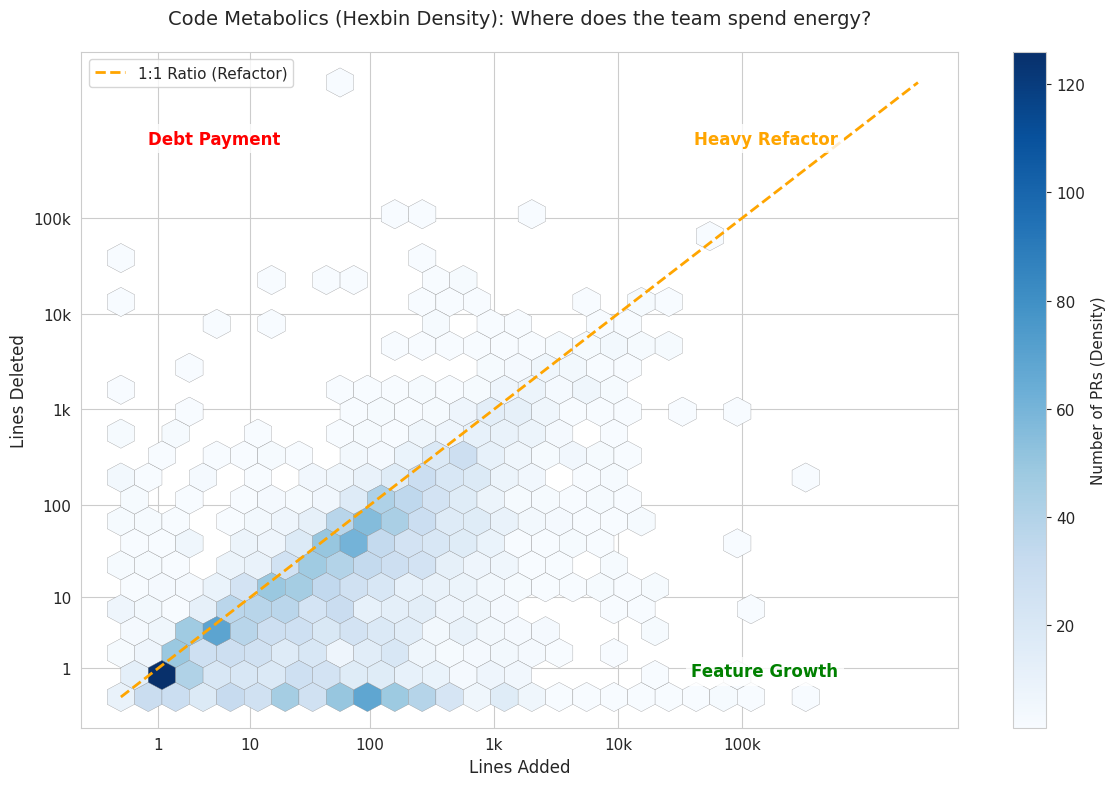

In [9]:
def plot_code_metabolics_hexbin(df):
    x = np.log1p(df['additions'])
    y = np.log1p(df['deletions'])
    
    plt.figure(figsize=(12, 8))
    
    hb = plt.hexbin(
        x, y,
        gridsize=25,
        cmap='Blues',
        mincnt=1,
        edgecolors='gray',
        linewidths=0.2
    )
    
    cb = plt.colorbar(hb, label='Number of PRs (Density)')
    
    max_val = max(x.max(), y.max())
    plt.plot(
        [0, max_val],
        [0, max_val],
        '--',
        color='orange',
        linewidth=2,
        label='1:1 Ratio (Refactor)'
    )
    
    ticks = [1, 10, 100, 1000, 10000, 100000]
    log_ticks = np.log1p(ticks)
    labels = ['1', '10', '100', '1k', '10k', '100k']
    
    plt.xticks(log_ticks, labels)
    plt.yticks(log_ticks, labels)
    
    plt.text(
        max_val * 0.9,
        0.5,
        'Feature Growth',
        color='green',
        fontweight='bold',
        ha='right',
        fontsize=12,
        bbox=dict(facecolor='white', alpha=0.8, edgecolor='none')
    )
    
    plt.text(
        0.5,
        max_val * 0.9,
        'Debt Payment',
        color='red',
        fontweight='bold',
        ha='left',
        fontsize=12,
        bbox=dict(facecolor='white', alpha=0.8, edgecolor='none')
    )

    plt.text(
        max_val * 0.9,
        max_val * 0.9,
        'Heavy Refactor',
        color='orange',
        fontweight='bold',
        ha='right',
        fontsize=12,
        bbox=dict(facecolor='white', alpha=0.8, edgecolor='none')
    )

    plt.title(
        'Code Metabolics (Hexbin Density): Where does the team spend energy?',
        fontsize=14,
        pad=20
    )
    plt.xlabel('Lines Added', fontsize=12)
    plt.ylabel('Lines Deleted', fontsize=12)
    plt.legend(loc='upper left')
    
    plt.tight_layout()
    plt.show()

plot_code_metabolics_hexbin(df)


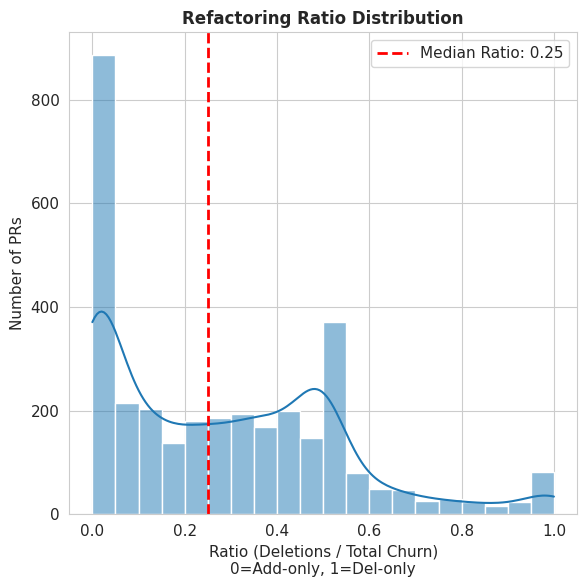

In [10]:
def plot_maintenance_patterns(df):
    df['refactor_ratio'] = df.apply(
        lambda x: x['deletions'] / x['churn'] if x['churn'] > 0 else 0,
        axis=1
    )

    plt.figure(figsize=(6, 6))
    
    sns.histplot(
        df['refactor_ratio'],
        kde=True,
        color=COLOR_LINE_1,
        bins=20
    )
    
    median_ratio = df['refactor_ratio'].median()
    plt.axvline(
        median_ratio,
        color='red',
        linestyle='--',
        linewidth=2,
        label=f'Median Ratio: {median_ratio:.2f}'
    )
    
    plt.title('Refactoring Ratio Distribution', fontsize=12, fontweight='bold')
    plt.xlabel('Ratio (Deletions / Total Churn)\n0=Add-only, 1=Del-only')
    plt.ylabel('Number of PRs')
    plt.legend()

    plt.tight_layout()
    plt.show()
    
    
plot_maintenance_patterns(df)


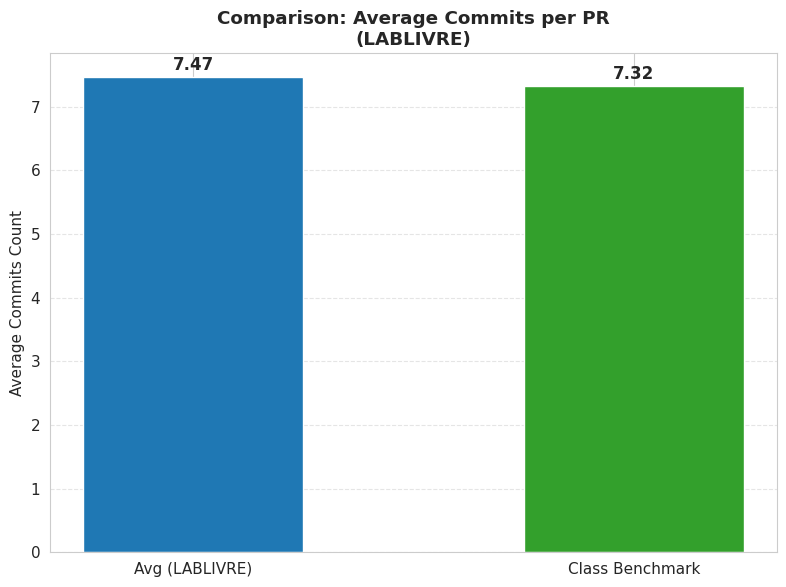

In [ ]:
## CLASS BENCH MARKET (UNB-MDS e REQMDS)
avg_commits = df['commits'].mean()
CLASS_BENCHMARK_COMMITS = 7.32

x_labels = [f'Avg ({org_title})', 'Class Benchmark']
y_values = [avg_commits, CLASS_BENCHMARK_COMMITS]

bar_colors = [COLOR_LINE_1, COLOR_LINE_2] 

plt.figure(figsize=(8, 6))
bars = plt.bar(x_labels, y_values, color=bar_colors, width=0.5)

plt.title(f'Comparison: Average Commits per PR\n({org_title})', fontweight='bold')
plt.ylabel('Average Commits Count')
plt.grid(axis='y', linestyle='--', alpha=0.5)

for bar in bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2., height + 0.05,
             f'{height:.2f}',
             ha='center', va='bottom', fontsize=12, fontweight='bold')

plt.tight_layout()
plt.show()

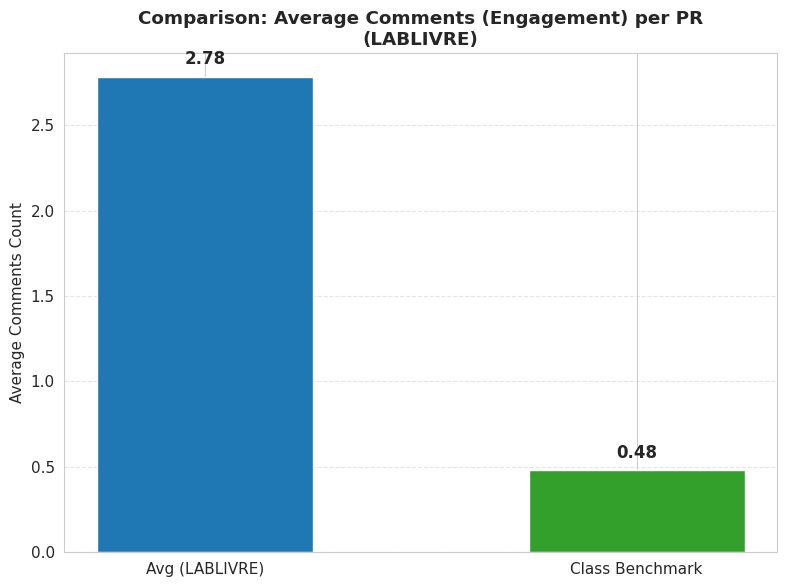

In [17]:

avg_comments = df['comments'].mean()
CLASS_BENCHMARK_COMMENTS = 0.48

x_labels = [f'Avg ({org_title})', 'Class Benchmark']
y_values = [avg_comments, CLASS_BENCHMARK_COMMENTS]

bar_colors = [COLOR_LINE_1, COLOR_LINE_2]

plt.figure(figsize=(8, 6))
bars = plt.bar(x_labels, y_values, color=bar_colors, width=0.5)

plt.title(f'Comparison: Average Comments (Engagement) per PR\n({org_title})', fontweight='bold')
plt.ylabel('Average Comments Count')
plt.grid(axis='y', linestyle='--', alpha=0.5)

for bar in bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2., height + 0.05,
             f'{height:.2f}',
             ha='center', va='bottom', fontsize=12, fontweight='bold')

plt.tight_layout()
plt.show()